# Homework 3: ODE Solvers

This is the second component of the homework.

## Q3:

Write an ODE package that includes Euler's method, Heun's method, and the explicit RK4 method...

**This is found in ode.py.**

In [1]:
%matplotlib inline
import numpy as np
from matplotlib.pyplot import *
from matplotlib import rc
from scipy.integrate import odeint

from ode import euler, heun, RK4

# Make more readable plots
rc('font',**{'size':14})
rc('xtick',**{'labelsize':16})
rc('ytick',**{'labelsize':16})
rc('axes',**{'labelsize':18,'titlesize':18})

-----

## Q4: 

Test your three functions against the damped pendulum example in scipy's `odeint()` documentation. Of course, your functions do not have to receive input in the same way that `odeint()` does. Make some plots to demonstrate that things are working as they should.

Here I will reproduce scipy's `odeint()` example with the damped pendulum

In [2]:
def pend(y, t, b, c):
    theta, omega = y
    dydt = [omega, -b*omega - c*np.sin(theta)]
    return dydt

b = 0.25
c = 5.0
y0 = [np.pi - 0.1, 0.0]
ts = np.linspace(0, 10, 101)
sol = odeint(pend, y0, ts, args=(b, c))

In [3]:
# Convenience function for plots below
def double_pendulum_plot(t, y1, y2, label1=r'$\theta(t)$', label2=r'$\omega(t)$'):
    plot(t, y1, 'b', label=r'$\theta(t)$')
    plot(t, y2, 'g', label=r'$\omega(t)$')
    legend(loc='best')
    xlabel('$t$')
    grid()
    show()

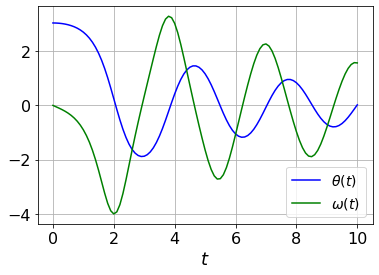

In [4]:
double_pendulum_plot(ts, sol[:, 0], sol[:, 1])

Now I will work the derivative functions into the form taken by my functions. I will write these in lambda notation.

To be clear, in the math notation, the two equations originally written as

$$
\begin{eqnarray*}
\theta'(t) & = & \omega(t) \\
\omega'(t) & = & -b\omega(t) - c \sin[\theta(t)]
\end{eqnarray*}
$$

In the notation using variables $\vec{y}(t) = [y_A(t), y_B(t)] = [\theta(t), \omega(t)]$, then we can rewrite as

$$
\begin{eqnarray*}
y_A'(t) & = & y_B(t) \\
y_B'(t) & = & -by_B(t) - c \sin[y_A\theta(t)]
\end{eqnarray*}
$$

In [5]:
dyAdt = lambda t, yA, yB: yB
dyBdt = lambda t, yA, yB: -b*yB - c*np.sin(yA)
yA0 = np.pi - 0.1
yB0 = 0.0

Using Euler's method, I'll run and then plot the solution.

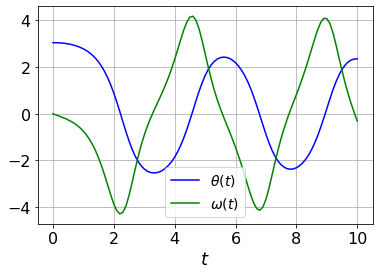

In [6]:
yAs, yBs = euler(ts, dyAdt, yA0, dyBdt, yB0)
double_pendulum_plot(ts, yAs, yBs)

You can see that this solution is quite poor compared to the solution via `odeint()`. However, if I up the number of timesteps, I get a much better solution.

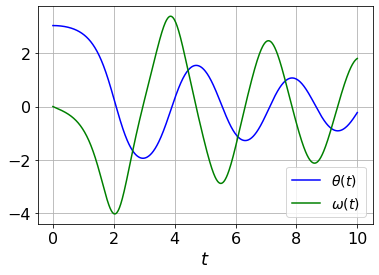

In [7]:
ts = np.linspace(0, 10, 1001)
yAs, yBs = euler(ts, dyAdt, yA0, dyBdt, yB0)
double_pendulum_plot(ts, yAs, yBs)

We can plot the differences between the two as well. We need to rerun `odeint()` and then compare the solutions

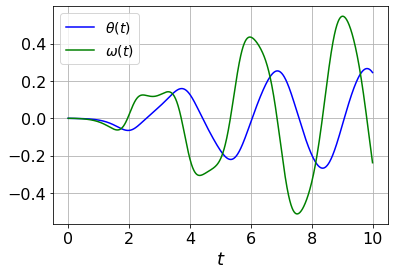

In [8]:
ts = np.linspace(0, 10, 1001)
sol = odeint(pend, y0, ts, args=(b, c))
double_pendulum_plot(ts, sol[:, 0]-yAs, sol[:, 1]-yBs, label1=r'$\Delta\theta(t)$', label2=r'$\Delta\omega(t)$')

We can do it again for increased time resolution

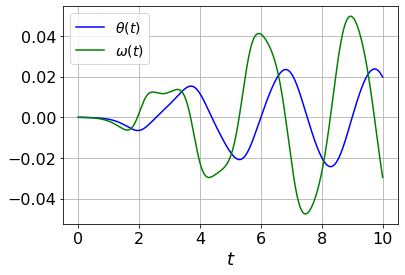

In [9]:
ts = np.linspace(0, 10, 10001)
yAs, yBs = euler(ts, dyAdt, yA0, dyBdt, yB0)
sol = odeint(pend, y0, ts, args=(b, c))
double_pendulum_plot(ts, sol[:, 0]-yAs, sol[:, 1]-yBs, label1=r'$\Delta\theta(t)$', label2=r'$\Delta\omega(t)$')

Taking a look at the amplitude on the y axis, we can see that we are doing much better, and by the factor of 10 that we expect given that the Euler method has $\mathcal{O}(h)$ errors.

Now let's take a look at the other methods.

In [10]:
# Rerun scipy's version at 101 timesteps
ts = np.linspace(0, 10, 101)
sol = odeint(pend, y0, ts, args=(b, c))

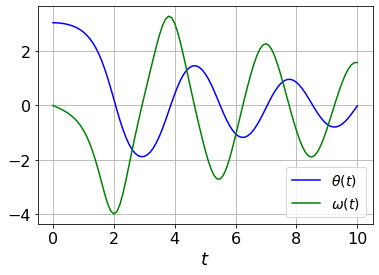

In [11]:
yAs, yBs = heun(ts, dyAdt, yA0, dyBdt, yB0, niter=10)
double_pendulum_plot(ts, yAs, yBs)

Let's take a look at the differences now.

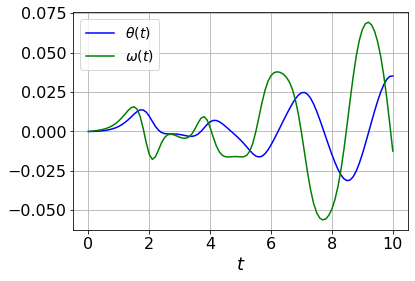

In [12]:
double_pendulum_plot(ts, sol[:, 0]-yAs, sol[:, 1]-yBs, label1=r'$\Delta\theta(t)$', label2=r'$\Delta\omega(t)$')

You can see that just with 101 timesteps, and just 10 Picard iterations, we do significantly better, of the same order as when we had 10001 timesteps.

Let's quickly repeat with the RK4 method.

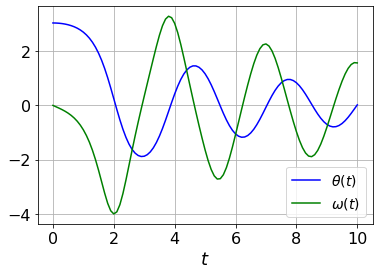

In [13]:
yAs, yBs = RK4(ts, dyAdt, yA0, dyBdt, yB0)
double_pendulum_plot(ts, yAs, yBs)

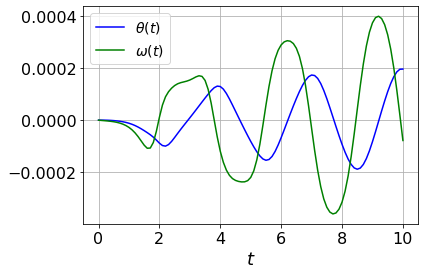

In [14]:
double_pendulum_plot(ts, sol[:, 0]-yAs, sol[:, 1]-yBs, label1=r'$\Delta\theta(t)$', label2=r'$\Delta\omega(t)$')

Given the $y$ axis scale, you can see just how powerful this method is.

-----

## Q5:


Test your three methods against the following stiff ODE:

$$
\frac{dy}{dt} = -\lambda(y-\cos(t)), \quad\quad\quad y(0) = 0
$$
where $\lambda$ is a constant. As $\lambda$ increases, the equation typically becomes stiffer, so pick maybe $\lambda \ge 10$. So that you can check your results, the solution to this equation is:
$$
y(t) = -\frac{\lambda^2}{1+\lambda^2} e^{-\lambda t} + \frac{\lambda}{1+\lambda^2}\sin(t) + \frac{\lambda^2}{1+\lambda^2}\cos(t).
$$
Provide some comments about the stability of each.


I will show for $\lambda = 20$. First, let's see what the solution looks like:

In [15]:
lam = 20
def y_comp(t, lam):
    lamsq = lam**2
    denom = 1 + lamsq
    return -(lamsq/denom)*np.exp(-lam*t) + (lam/denom)*np.sin(t) + (lamsq/denom)*np.cos(t)

In [16]:
# Convenience function for plots below
def stiffeq_plot(t, y, label=r'$y(t)$'):
    plot(t, y, 'b')
    xlabel(r'$t$')
    ylabel(label)
    grid()
    show()

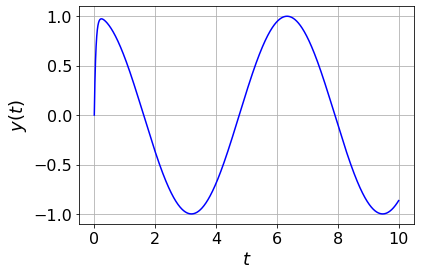

In [17]:
ts = np.linspace(0, 10, 10001)
comp = y_comp(ts, lam)
stiffeq_plot(ts, comp)

Now I'll use my solvers. First I will setup things in my notation.

In [18]:
dydt = lambda t, y: -20*(y-np.cos(t))
y0 = 0.0

Now I will solve via Euler's method and plot.

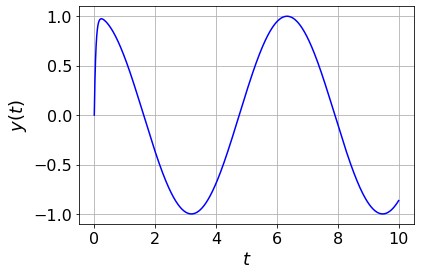

In [19]:
ys = euler(ts, dydt, y0)
stiffeq_plot(ts, ys)

Let's look at the differences in the solution.

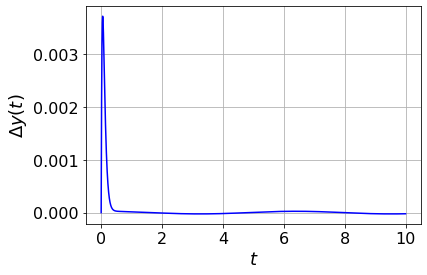

In [20]:
stiffeq_plot(ts, ys-comp, label=r'$\Delta y(t)$')

So, this is not terrible but the beginning is obviously pretty rough.

Now I'll try Heun's method, but this time, I'll see what happens if I decrease the number of timesteps by a factor of 3, and then use just 3 Picard iterations, thus keeping a comparable number of base computations.

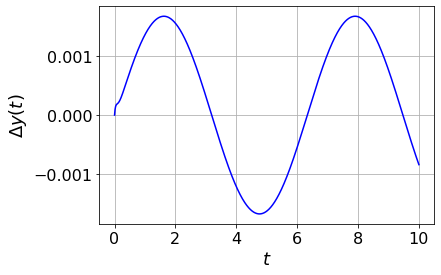

In [21]:
ts = np.linspace(0, 10, 3001)
comp = y_comp(ts, lam)
ys = heun(ts, dydt, y0, niter=3)
stiffeq_plot(ts, ys-comp, label=r'$\Delta y(t)$')

And that's much better than using Euler's method and just increasing the timesteps by a factor of 10 (again, because the error is $\mathcal{O}(h)$).

Now, time for RK4:

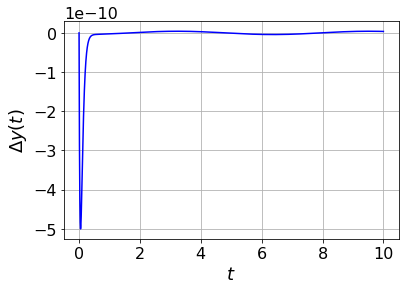

In [22]:
ts = np.linspace(0, 10, 10001)
comp = y_comp(ts, lam)
ys = RK4(ts, dydt, y0)
stiffeq_plot(ts, ys-comp, label=r'$\Delta y(t)$')

As you can see, the error is incredibly tiny. We could even reduce the number of timesteps by a factor of 10 and still get a very tiny resultant error:

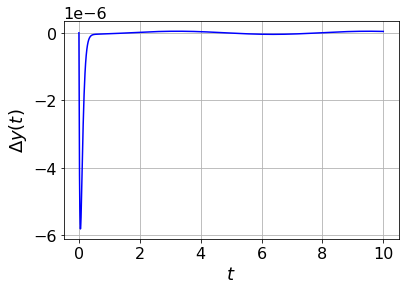

In [23]:
ts = np.linspace(0, 10, 1001)
comp = y_comp(ts, lam)
ys = RK4(ts, dydt, y0)
stiffeq_plot(ts, ys-comp, label=r'$\Delta y(t)$')

I will note that as $\lambda$ gets much larger, even these methods will suffer drastically. This is where something like `odeint()` and its RK5(4) method starts to shine, given that you are performing the Runge-Kutta methods but also with Picard-type corrector steps; the classical RK4 method given here is only explicit with no corrector steps given.